In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df= pd.read_csv("traffic.csv")
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
df.shape

(48120, 4)

In [4]:
df.columns

Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [6]:
df.describe(include="all")

,DateTime,Junction,Vehicles,ID
count,48120,48120.000000,48120.000000,4.812000e+04
unique,14592,NaN,NaN,NaN
top,2017-06-30 23:00:00,NaN,NaN,NaN
freq,4,NaN,NaN,NaN
mean,NaN,2.180549,22.791334,2.016330e+10
std,NaN,0.966955,20.750063,5.944854e+06
min,NaN,1.000000,1.000000,2.015110e+10
25%,NaN,1.000000,9.000000,2.016042e+10
50%,NaN,2.000000,15.000000,2.016093e+10
75%,NaN,3.000000,29.000000,2.017023e+10


# Checking the quality of data

In [7]:
df.isna().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [8]:
df.duplicated().sum()

0

# Checking for outliers

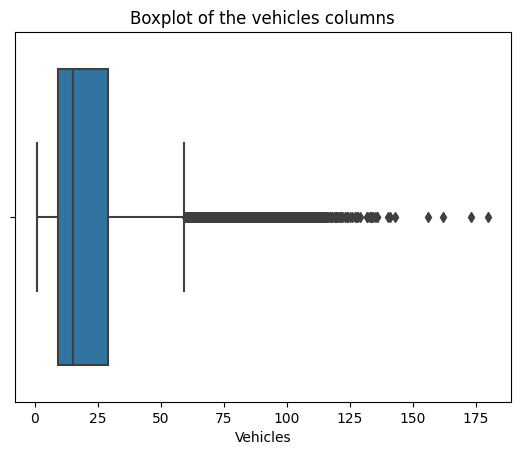

In [9]:
sns.boxplot(x=df['Vehicles'])
plt.title("Boxplot of the vehicles columns")
plt.show()

# Feature engineering

In [10]:
# Extracting time-related features
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute

In [11]:
# Aggregating data on an hourly basis
hourly_data = df.groupby(['Year', 'Month', 'Day', 'Hour']).agg({'Vehicles': 'mean'}).reset_index()
hourly_data

,Year,Month,Day,Hour,Vehicles
0,2015,11,1,0,10.000000
1,2015,11,1,1,8.666667
2,2015,11,1,2,6.666667
3,2015,11,1,3,4.666667
4,2015,11,1,4,6.000000
...,...,...,...,...,...
14587,2017,6,30,19,45.750000
14588,2017,6,30,20,48.000000
14589,2017,6,30,21,41.250000
14590,2017,6,30,22,40.250000


In [12]:
# Creating lag features
df['Vehicles_Lag1'] = df['Vehicles'].shift(1)
df['Vehicles_Lag3'] = df['Vehicles'].shift(3)


In [13]:
# Calculating rolling mean and standard deviation
df['Vehicles_Mean'] = df['Vehicles'].rolling(window=3).mean()
df['Vehicles_Std'] = df['Vehicles'].rolling(window=3).std()


In [14]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Day,DayOfWeek,Hour,Minute,Vehicles_Lag1,Vehicles_Lag3,Vehicles_Mean,Vehicles_Std
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,6,0,0,NaN,NaN,NaN,NaN
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,6,1,0,15.0,NaN,NaN,NaN
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,6,2,0,13.0,NaN,12.666667,2.516611
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,6,3,0,10.0,15.0,10.000000,3.000000
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,6,4,0,7.0,13.0,8.666667,1.527525


# Exploratory data analysis

# Univariate analysis

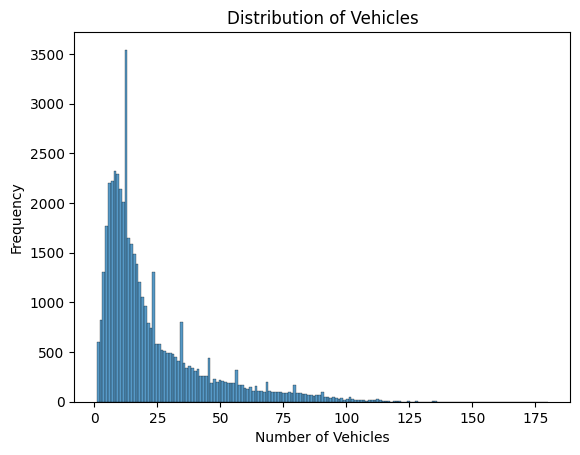

In [15]:
# Univariate analysis of 'Vehicles'
sns.histplot(df['Vehicles'])
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')
plt.title('Distribution of Vehicles')
plt.show()

# Bivariate analysis

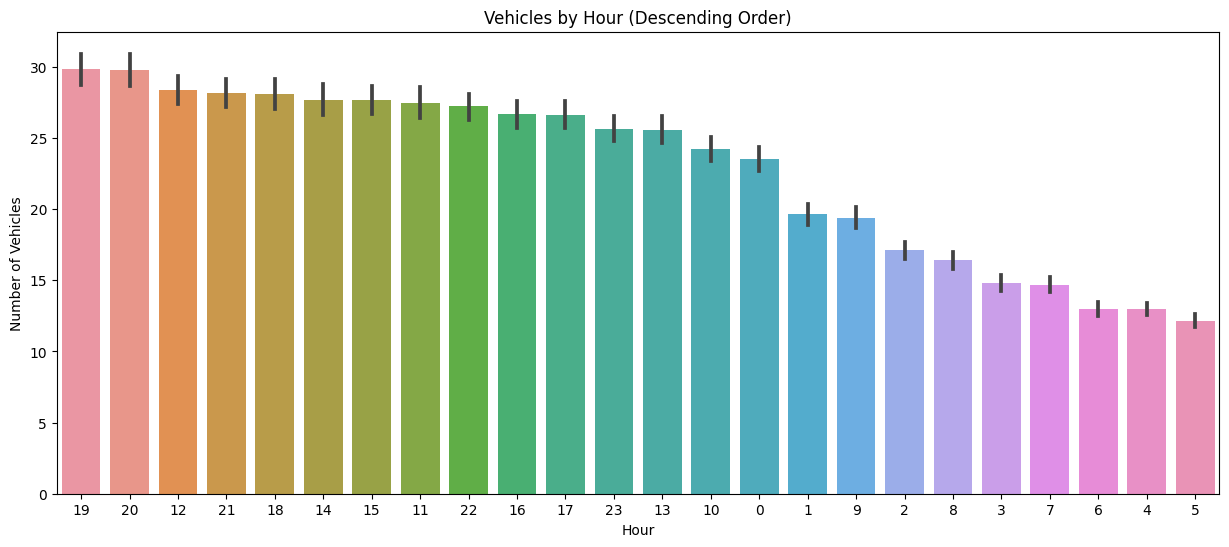

In [16]:
# Relationship between 'Vehicles' and 'Hour'

plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='Hour', y='Vehicles',
            order=df.groupby('Hour')['Vehicles'].mean().sort_values(ascending=False).index)
plt.xlabel('Hour')
plt.ylabel('Number of Vehicles')
plt.title('Vehicles by Hour (Descending Order)')
plt.show()


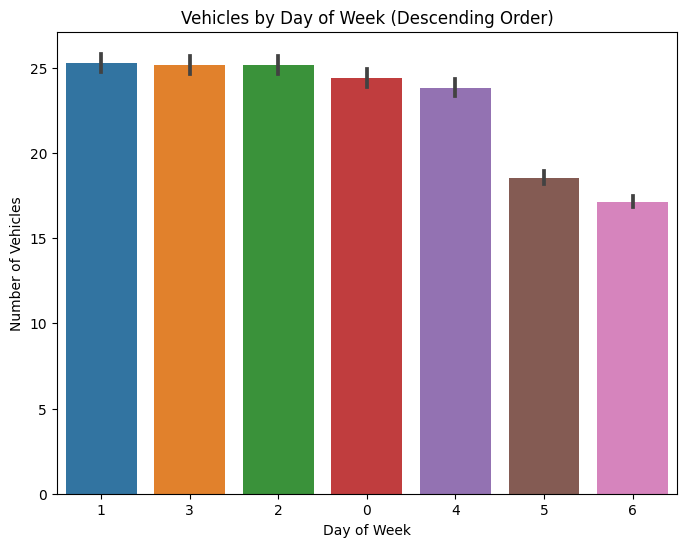

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='DayOfWeek', y='Vehicles',
            order=df.groupby('DayOfWeek')['Vehicles'].mean().sort_values(ascending=False).index)
plt.xlabel('Day of Week')
plt.ylabel('Number of Vehicles')
plt.title('Vehicles by Day of Week (Descending Order)')
plt.show()

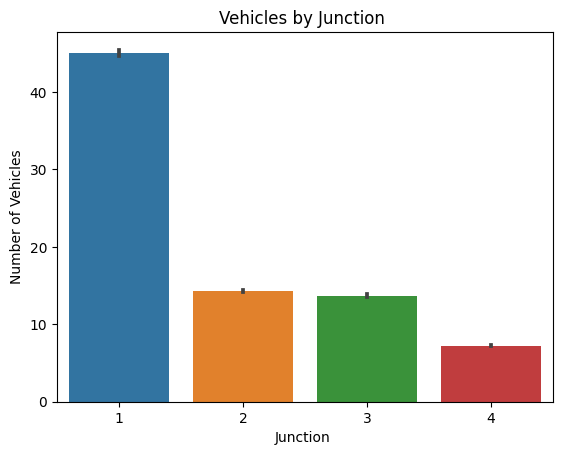

In [18]:
# Relationship between 'Vehicles' and 'Junction'
sns.barplot(data=df, x='Junction', y='Vehicles')
plt.xlabel('Junction ')
plt.ylabel('Number of Vehicles')
plt.title('Vehicles by Junction ')
plt.show()

# Multivariate analysis

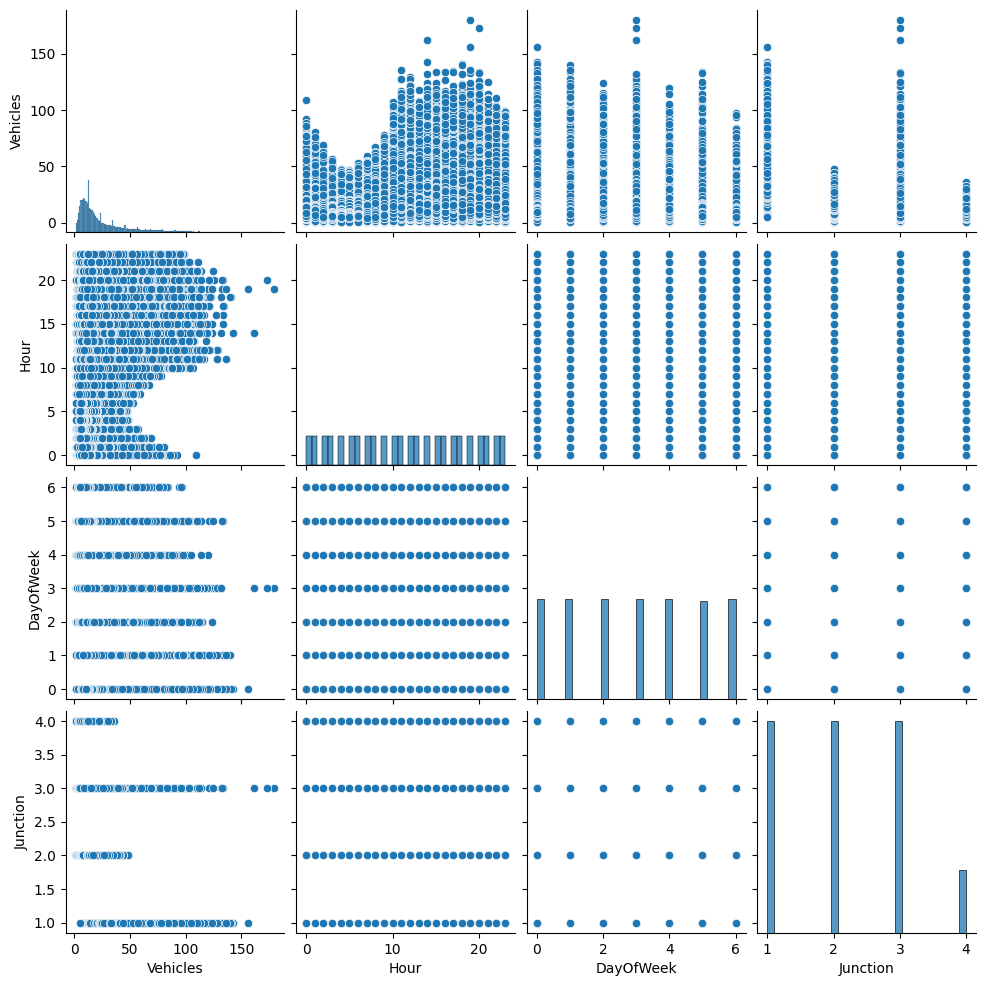

In [19]:
# Pairwise scatter plot of numeric columns
sns.pairplot(df[['Vehicles', 'Hour', 'DayOfWeek', 'Junction']])
plt.show()

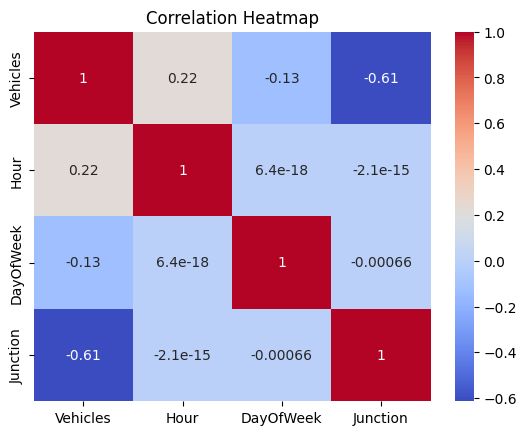

In [20]:
# Correlation heatmap
correlation_matrix = df[['Vehicles', 'Hour', 'DayOfWeek', 'Junction']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

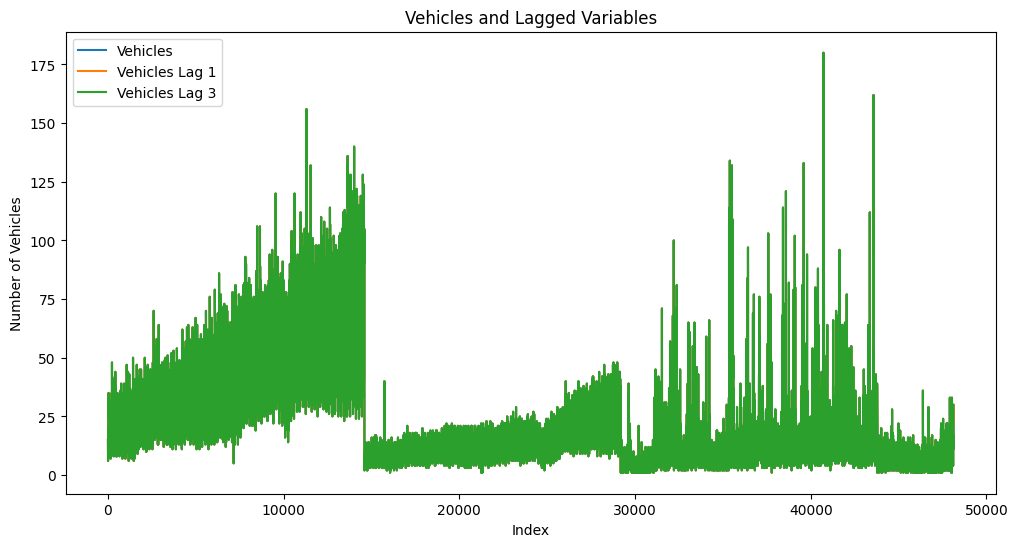

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df['Vehicles'], label='Vehicles')
plt.plot(df['Vehicles_Lag1'], label='Vehicles Lag 1')
plt.plot(df['Vehicles_Lag3'], label='Vehicles Lag 3')
plt.xlabel('Index')
plt.ylabel('Number of Vehicles')
plt.title('Vehicles and Lagged Variables')
plt.legend()
plt.show()


In [22]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Day,DayOfWeek,Hour,Minute,Vehicles_Lag1,Vehicles_Lag3,Vehicles_Mean,Vehicles_Std
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,6,0,0,NaN,NaN,NaN,NaN
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,6,1,0,15.0,NaN,NaN,NaN
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,6,2,0,13.0,NaN,12.666667,2.516611
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,6,3,0,10.0,15.0,10.000000,3.000000
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,6,4,0,7.0,13.0,8.666667,1.527525


In [23]:
# Convert 'DateTime' column to datetime format (if not already)
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set 'DateTime' column as the index
df.set_index('DateTime', inplace=True)

In [24]:
df.columns

Index(['Junction', 'Vehicles', 'ID', 'Year', 'Month', 'Day', 'DayOfWeek',
       'Hour', 'Minute', 'Vehicles_Lag1', 'Vehicles_Lag3', 'Vehicles_Mean',
       'Vehicles_Std'],
      dtype='object')

In [25]:
df.isna().sum()

Junction         0
Vehicles         0
ID               0
Year             0
Month            0
Day              0
DayOfWeek        0
Hour             0
Minute           0
Vehicles_Lag1    1
Vehicles_Lag3    3
Vehicles_Mean    2
Vehicles_Std     2
dtype: int64

In [26]:
# Filling missing values with column mean
df['Vehicles_Lag1'].fillna(0, inplace=True)
df['Vehicles_Lag3'].fillna(0, inplace=True)
df['Vehicles_Mean'].fillna(0, inplace=True)
df['Vehicles_Std'].fillna(0, inplace=True)


# Model building

In [27]:


# Splitting the dataset
X = df[['Year', 'Month', 'Day', 'DayOfWeek', 'Hour', 'Minute', 'Vehicles_Lag1', 'Vehicles_Lag3', 'Vehicles_Mean', 'Vehicles_Std']]
y = df['Vehicles']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Linear regression

In [28]:



lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [29]:
# Make predictions using Linear Regression model
lr_predictions = lr_model.predict(X_test)

# Calculate MSE, RMSE, and MAE for Linear Regression model
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_rmse = mean_squared_error(y_test, lr_predictions, squared=False)
lr_mae = mean_absolute_error(y_test, lr_predictions)

print("Linear Regression Metrics:")
print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
print("MAE:", lr_mae)
print()

Linear Regression Metrics:
MSE: 7.288696652559981
RMSE: 2.69975862857404
MAE: 1.7997780468286784



# Random forest regressor

In [30]:


# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
# Make predictions using Random Forest Regressor
rf_predictions = rf_model.predict(X_test)


# Calculate MSE, RMSE, and MAE for Random Forest Regressor
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
rf_mae = mean_absolute_error(y_test, rf_predictions)

print("Random Forest Metrics:")
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("MAE:", rf_mae)
print()

Random Forest Metrics:
MSE: 4.1519078761429755
RMSE: 2.0376230947216354
MAE: 1.1600145469659184



# Gradient Boosting regressor

In [32]:

# Initialize and train the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [33]:

# Make predictions using Gradient Boosting Regressor
gb_predictions = gb_model.predict(X_test)

# Calculate MSE, RMSE, and MAE for Gradient Boosting Regressor
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_rmse = mean_squared_error(y_test, gb_predictions, squared=False)
gb_mae = mean_absolute_error(y_test, gb_predictions)

print("Gradient Boosting Metrics:")
print("MSE:", gb_mse)
print("RMSE:", gb_rmse)
print("MAE:", gb_mae)

Gradient Boosting Metrics:
MSE: 5.774373745622074
RMSE: 2.4029926644961015
MAE: 1.568616529403251


# K nearest neighbors

In [34]:

k_values = range(1, 10)

mse_values = []
rmse_values = []
mae_values = []

# Iterate over different values of k
for k in k_values:
    # Define and train the K-Nearest Neighbors model
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    # Make predictions using the K-Nearest Neighbors model
    knn_predictions = knn_model.predict(X_test)

    # Calculate MSE, RMSE, and MAE for the K-Nearest Neighbors model
    mse = mean_squared_error(y_test, knn_predictions)
    rmse = mean_squared_error(y_test, knn_predictions, squared=False)
    mae = mean_absolute_error(y_test, knn_predictions)

    # Append the evaluation metrics to the respective lists
    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)

In [35]:
print(mse_values)
print(rmse_values)
print(mae_values)

[10.775145469659185, 8.709995843724023, 7.875196268587788, 7.608537250623441, 7.585249376558604, 7.575468158307933, 7.522382394354249, 7.479611518079801, 7.465797953675482]
[3.2825516705238904, 2.951270208524462, 2.806278009853583, 2.758357708968045, 2.7541331443048653, 2.7523568370231235, 2.742696190677022, 2.734887843784421, 2.732361241431206]
[2.2520781379883625, 1.982959268495428, 1.8890274314214464, 1.8511273898586866, 1.8395469659185373, 1.830545164865614, 1.8250356252226578, 1.8238258520365753, 1.829569594532188]


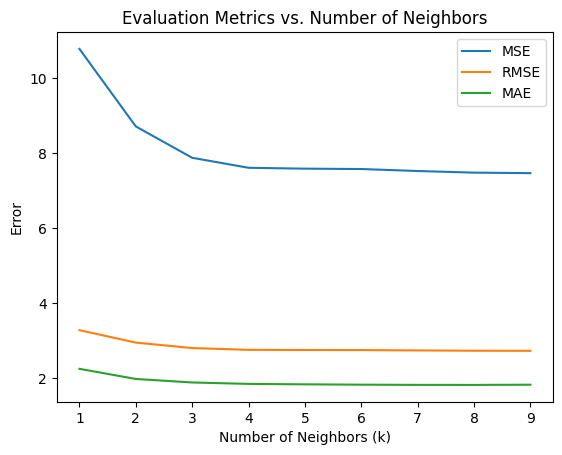

In [36]:
# Plotting the evaluation metrics against different values of k
plt.plot(k_values, mse_values, label='MSE')
plt.plot(k_values, rmse_values, label='RMSE')
plt.plot(k_values, mae_values, label='MAE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.title('Evaluation Metrics vs. Number of Neighbors')
plt.legend()
plt.show()

# Hyperparameter tunning

## Random forest

In [37]:

# Random Forest Regressor
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, scoring='neg_mean_squared_error', cv=5,n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [38]:
rf_best_model = rf_grid.best_estimator_
rf_best_predictions = rf_best_model.predict(X_test)

rf_best_mse = mean_squared_error(y_test, rf_best_predictions)
rf_best_rmse = mean_squared_error(y_test, rf_best_predictions, squared=False)
rf_best_mae = mean_absolute_error(y_test, rf_best_predictions)

print(rf_best_model)

print("Random Forest Metrics (After Hyperparameter Tuning):")
print("MSE:", rf_best_mse)
print("RMSE:", rf_best_rmse)
print("MAE:", rf_best_mae)
print()

RandomForestRegressor(n_estimators=300, random_state=42)
Random Forest Metrics (After Hyperparameter Tuning):
MSE: 4.133038271220097
RMSE: 2.0329875236262756
MAE: 1.1537236769188142



## Gradient boosting

In [39]:
# Gradient Boosting Regressor
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 10]
}

gb_model = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(gb_model, gb_params, scoring='neg_mean_squared_error', cv=5,n_jobs=-1)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [40]:
gb_best_model = gb_grid.best_estimator_
gb_best_predictions = gb_best_model.predict(X_test)

gb_best_mse = mean_squared_error(y_test, gb_best_predictions)
gb_best_rmse = mean_squared_error(y_test, gb_best_predictions, squared=False)
gb_best_mae = mean_absolute_error(y_test, gb_best_predictions)

print(gb_best_model)

print("Gradient Boosting Metrics (After Hyperparameter Tuning):")
print("MSE:", gb_best_mse)
print("RMSE:", gb_best_rmse)
print("MAE:", gb_best_mae)
print()

GradientBoostingRegressor(max_depth=5, n_estimators=300, random_state=42)
Gradient Boosting Metrics (After Hyperparameter Tuning):
MSE: 3.6697875048725765
RMSE: 1.915668944487167
MAE: 1.1127420193102615



# KNN

In [41]:
# K-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

knn_model = KNeighborsRegressor()
knn_grid = GridSearchCV(knn_model, knn_params, scoring='neg_mean_squared_error', cv=5,n_jobs=-1)
knn_grid.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [42]:
knn_best_model = knn_grid.best_estimator_
knn_best_predictions = knn_best_model.predict(X_test)

knn_best_mse = mean_squared_error(y_test, knn_best_predictions)
knn_best_rmse = mean_squared_error(y_test, knn_best_predictions, squared=False)
knn_best_mae = mean_absolute_error(y_test, knn_best_predictions)

print(knn_best_model)

print("K-Nearest Neighbors Metrics (After Hyperparameter Tuning):")
print("MSE:", knn_best_mse)
print("RMSE:", knn_best_rmse)
print("MAE:", knn_best_mae)
print()

KNeighborsRegressor(n_neighbors=7, weights='distance')
K-Nearest Neighbors Metrics (After Hyperparameter Tuning):
MSE: 7.344389145845203
RMSE: 2.710053347416837
MAE: 1.8084011861422622



# Stacking model

In [43]:


# Define the base models
base_models = [
    ('random_forest', RandomForestRegressor(random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(random_state=42)),
    ('linear_regression', LinearRegression()),
    ('k_neighbors', KNeighborsRegressor())
]


In [44]:

# Define the meta model (final estimator)
meta_model = LinearRegression()

# Define the stacking regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)


In [45]:
# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions using the stacking model
stacking_predictions = stacking_model.predict(X_test)


# Calculate MSE, RMSE, and MAE for Stacking Regressor
stacking_mse = mean_squared_error(y_test, stacking_predictions)
stacking_rmse = mean_squared_error(y_test, stacking_predictions, squared=False)
stacking_mae = mean_absolute_error(y_test, stacking_predictions)

print("Stacking Metrics:")
print("MSE:", stacking_mse)
print("RMSE:", stacking_rmse)
print("MAE:", stacking_mae)

Stacking Metrics:
MSE: 4.152787089553506
RMSE: 2.03783882815926
MAE: 1.2406626723318015


# Blending algorithm

In [46]:
# Define the base models
base_models = [
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    LinearRegression(),
    KNeighborsRegressor()
]

In [47]:
base_model_predictions = []

# Train the base models and collect predictions
for model in base_models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_train)
    base_model_predictions.append(predictions)


In [48]:
# Define the meta model (final estimator)
meta_model = LinearRegression()

# Combine the predictions of the base models
blending_X_train = np.column_stack(base_model_predictions)


In [49]:
# Train the blending model
meta_model.fit(blending_X_train, y_train)

# Collect predictions from the base models on the testing data
base_model_test_predictions = []
for model in base_models:
    predictions = model.predict(X_test)
    base_model_test_predictions.append(predictions)


In [50]:
# Combine the predictions of the base models on the testing data
blending_X_test = np.column_stack(base_model_test_predictions)

# Make predictions using the blending model
blending_predictions = meta_model.predict(blending_X_test)



# Calculate MSE, RMSE, and MAE for blending Regressor
blending_mse = mean_squared_error(y_test, blending_predictions)
blending_rmse = mean_squared_error(y_test, blending_predictions, squared=False)
blending_mae = mean_absolute_error(y_test, blending_predictions)

print("blending Metrics:")
print("MSE:", blending_mse)
print("RMSE:", blending_rmse)
print("MAE:", blending_mae)

blending Metrics:
MSE: 4.41262909228593
RMSE: 2.1006258810854277
MAE: 1.1868315038023542


# Forecasting the output

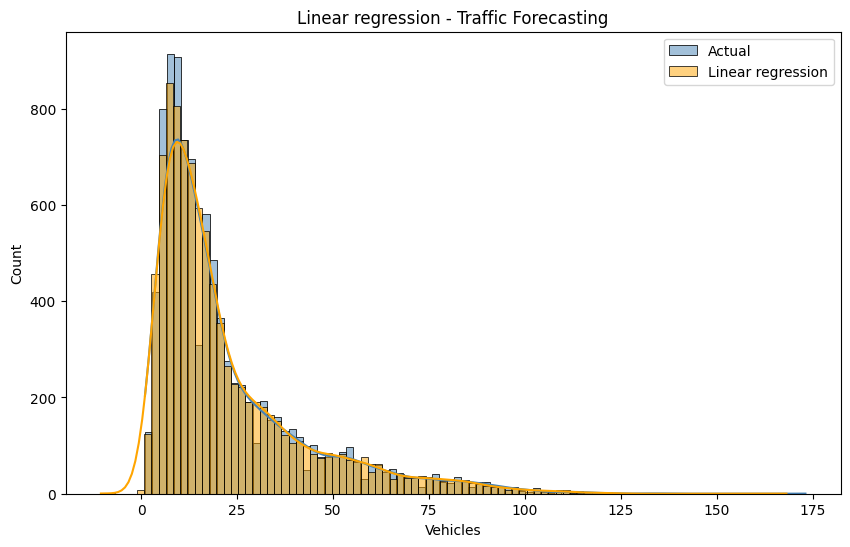

In [64]:
# Linear regression
plt.figure(figsize=(10, 6))
sns.histplot(data=y_test, color='steelblue', label='Actual', kde=True)
sns.histplot(data=lr_predictions, color='orange', label='Linear regression', kde=True)
plt.title('Linear regression - Traffic Forecasting')
plt.xlabel('Vehicles')
plt.ylabel('Count')
plt.legend()
plt.show()

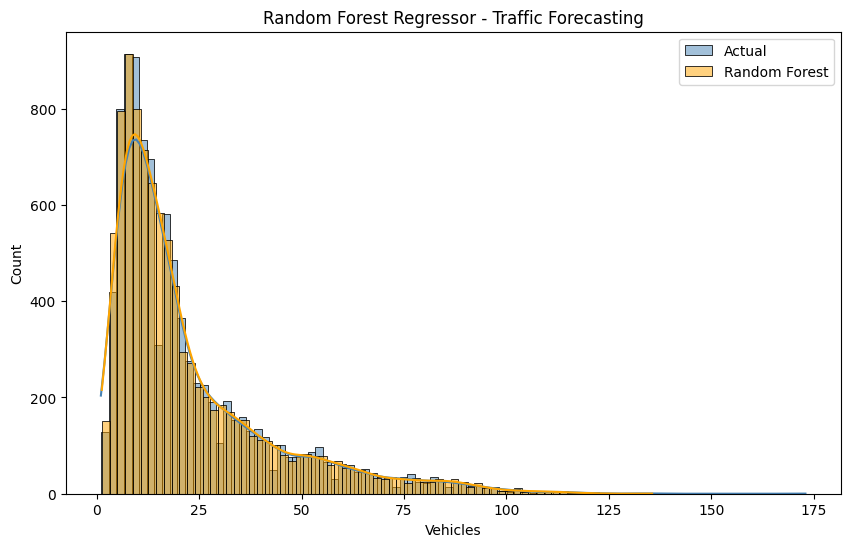

In [59]:
# Random Forest Regressor
plt.figure(figsize=(10, 6))
sns.histplot(data=y_test, color='steelblue', label='Actual', kde=True)
sns.histplot(data=rf_best_predictions, color='orange', label='Random Forest', kde=True)
plt.title('Random Forest Regressor - Traffic Forecasting')
plt.xlabel('Vehicles')
plt.ylabel('Count')
plt.legend()
plt.show()

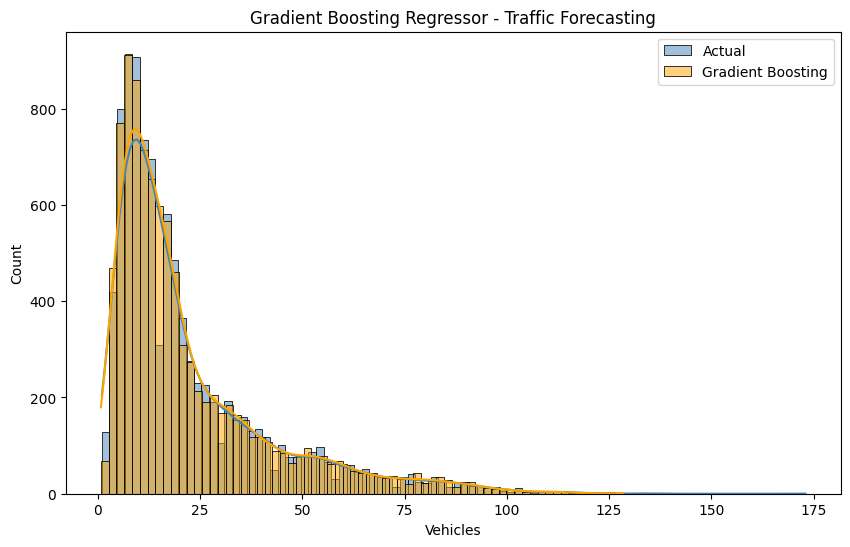

In [60]:
# Gradient Boosting Regressor
plt.figure(figsize=(10, 6))
sns.histplot(data=y_test, color='steelblue', label='Actual', kde=True)
sns.histplot(data=gb_best_predictions, color='orange', label='Gradient Boosting', kde=True)
plt.title('Gradient Boosting Regressor - Traffic Forecasting')
plt.xlabel('Vehicles')
plt.ylabel('Count')
plt.legend()
plt.show()


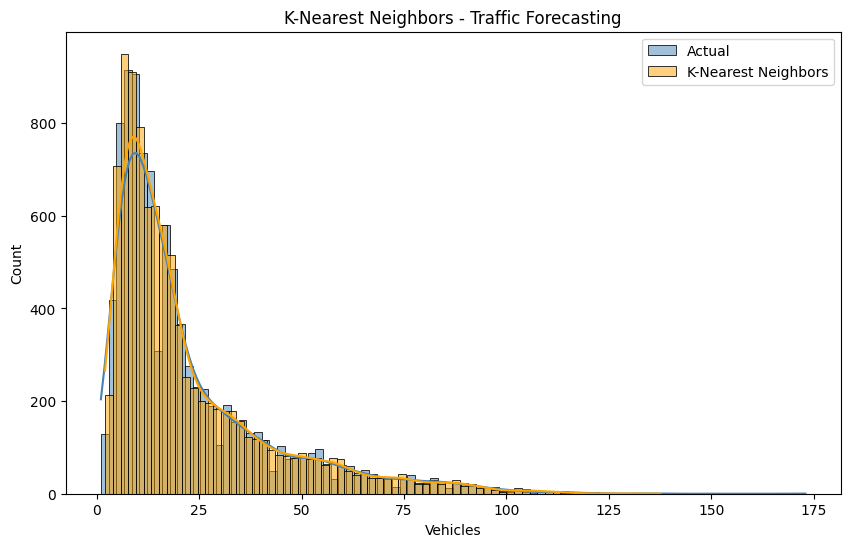

In [61]:
# K-Nearest Neighbors
plt.figure(figsize=(10, 6))
sns.histplot(data=y_test, color='steelblue', label='Actual', kde=True)
sns.histplot(data=knn_best_predictions, color='orange', label='K-Nearest Neighbors', kde=True)
plt.title('K-Nearest Neighbors - Traffic Forecasting')
plt.xlabel('Vehicles')
plt.ylabel('Count')
plt.legend()
plt.show()

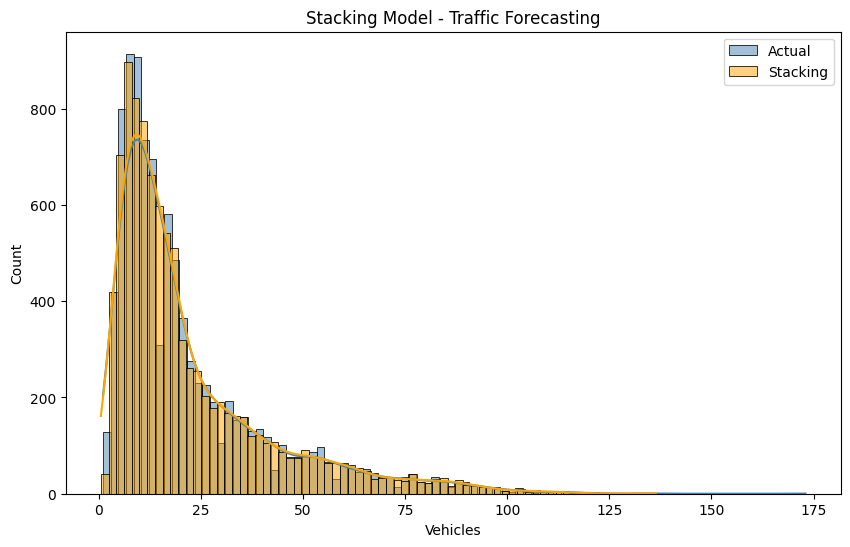

In [62]:
# Stacking Model
plt.figure(figsize=(10, 6))
sns.histplot(data=y_test, color='steelblue', label='Actual', kde=True)
sns.histplot(data=stacking_predictions, color='orange', label='Stacking', kde=True)
plt.title('Stacking Model - Traffic Forecasting')
plt.xlabel('Vehicles')
plt.ylabel('Count')
plt.legend()
plt.show()

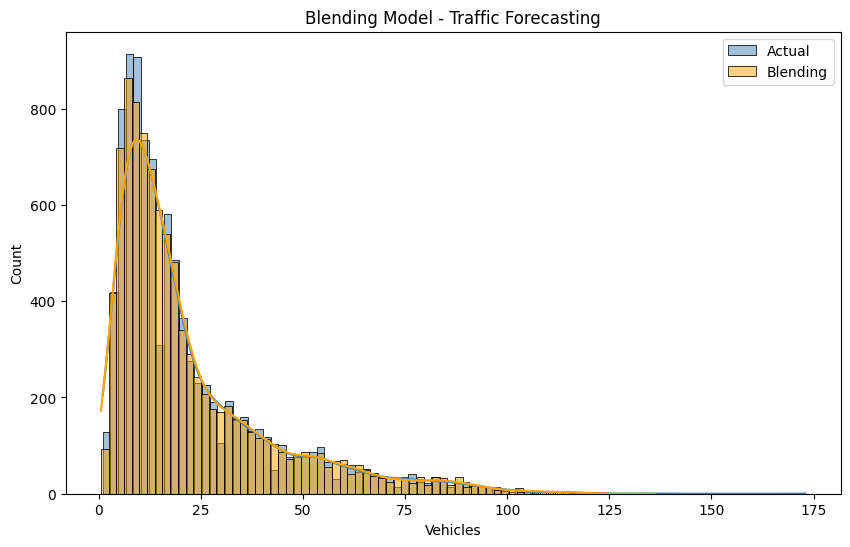

In [63]:
# blending Model
plt.figure(figsize=(10, 6))
sns.histplot(data=y_test, color='steelblue', label='Actual', kde=True)
sns.histplot(data=blending_predictions, color='orange', label='Blending', kde=True)
plt.title('Blending Model - Traffic Forecasting')
plt.xlabel('Vehicles')
plt.ylabel('Count')
plt.legend()
plt.show()